In [478]:
import tensorflow as tf

In [480]:
import keras as keras


In [482]:
tf. __version__

'2.16.1'

In [484]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [486]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [488]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [490]:

gpus

NameError: name 'gpus' is not defined

In [492]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [10]:
# http://vis-www.cs.umass.edu/lfw/

In [11]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [12]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [494]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

In [496]:
# Import uuid library to generate unique image names
import uuid

In [498]:
# os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [500]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [501]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [91]:
# plt.imshow(frame)

In [33]:
# frame.shape

In [307]:
######### GET IMAGE DIRECTORY ###########

In [504]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [506]:
dir_test = anchor.as_numpy_iterator()

In [508]:
print(dir_test.next())


b'data\\anchor\\e04a1123-4bc4-11ef-83d6-005056c00008.jpg'


In [510]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [512]:
img = preprocess('data\\anchor\\52b44ee8-36bd-11ef-a066-e0d045acbbfb.jpg')


In [514]:
img.numpy().max() 


1.0

In [516]:
dataset.map(preprocess)


NameError: name 'dataset' is not defined

In [50]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [518]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [520]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [522]:
samples = data.as_numpy_iterator()


In [524]:
exampple = samples.next()


In [526]:
exampple

(b'data\\anchor\\76636d3c-36bd-11ef-ae7c-e0d045acbbfb.jpg',
 b'data\\positive\\03bfc3ab-4bc5-11ef-a164-005056c00008.jpg',
 1.0)

In [528]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [530]:
res = preprocess_twin(*exampple)


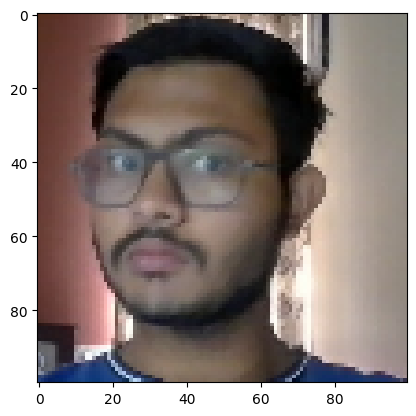

In [532]:
plt.imshow(res[0])


In [534]:
res[2]


1.0

In [536]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()   #loading images into the cache memory
data = data.shuffle(buffer_size=1024) #mixing up the dataset to contain both positive and negetive images in random order for training and testing

In [538]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [540]:
# samples = data.as_numpy_iterator()

In [542]:
# samp = samples.next()

In [544]:
# plt.imshow(samp[0])

In [546]:
# plt.imshow(samp[1])

In [548]:
# samp[2]

In [550]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)  #creating a training batch of 16 images
train_data = train_data.prefetch(8)

In [552]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)  #creating a testing batch of 16 images
test_data = test_data.prefetch(8)

In [554]:
train_samples= train_data.as_numpy_iterator()

In [556]:
train_sample=train_samples.next()

In [440]:
### Build Embedding Layer ###

In [442]:
# inp = Input(shape=(100,100,3), name='input_image')

In [201]:
# c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [203]:
# m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [334]:
# c2 = Conv2D(128, (7,7), activation='relu')(m1)
# m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [335]:
# c3 = Conv2D(128, (4,4), activation='relu')(m2)
# m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [336]:
# c4 = Conv2D(256, (4,4), activation='relu')(m3)
# f1 = Flatten()(c4)
# d1 = Dense(4096, activation='sigmoid')(f1)

In [337]:
# mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [205]:
# mod.summary()


In [558]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [560]:
embedding = make_embedding()


In [562]:
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [570]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # if isinstance(input_embedding, list):
        #     input_embedding = input_embedding[0]
        # if isinstance(validation_embedding, list):
        #     validation_embedding = validation_embedding[0]
        return tf.math.abs(input_embedding - validation_embedding)

In [572]:
l1 = L1Dist()

In [574]:
l1(anchor_embedding, validation_embedding)


NameError: name 'anchor_embedding' is not defined

In [576]:
##### MAKE SIAMESE MODEL #####

In [578]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [580]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [582]:
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_54>]

In [584]:
siamese_layer = L1Dist()

In [586]:
siamese_layer(inp_embedding,val_embedding)

TypeError: Exception encountered when calling L1Dist.call().

[1munsupported operand type(s) for -: 'list' and 'list'[0m

Arguments received by L1Dist.call():
  • args=(['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_54>'], ['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_55>'])
  • kwargs=<class 'inspect._empty'>

In [588]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [590]:
distances = siamese_layer(inp_embedding, val_embedding)

TypeError: Exception encountered when calling L1Dist.call().

[1munsupported operand type(s) for -: 'list' and 'list'[0m

Arguments received by L1Dist.call():
  • args=(['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_54>'], ['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_55>'])
  • kwargs=<class 'inspect._empty'>

In [592]:
siamese_layer=L1Dist()

In [594]:
siamese_layer


<L1Dist name=l1_dist_22, built=False>

In [596]:
classifier = Dense(1, activation='sigmoid')(distances)


In [598]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_56>

In [600]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


ValueError: The name "input_img" is used 2 times in the model. All operation names should be unique.

In [602]:
siamese_network.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_15 (L1Dist) │ (None, 4096)      │          0 │ embedding[16][0], │
│                     │                   │            │ embedding[17][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [604]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [606]:
siamese_model = make_siamese_model()


TypeError: Exception encountered when calling L1Dist.call().

[1munsupported operand type(s) for -: 'list' and 'list'[0m

Arguments received by L1Dist.call():
  • args=(['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_57>'], ['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_58>'])
  • kwargs=<class 'inspect._empty'>

In [608]:
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_18 (L1Dist) │ (None, 4096)      │          0 │ embedding[20][0], │
│                     │                   │            │ embedding[21][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [610]:
##### Setup Loss and Optimizer #####

In [612]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [614]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001


In [616]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [618]:
test_batch = train_data.as_numpy_iterator()


In [620]:
batch_1 = test_batch.next()


In [622]:
batch_1[2]

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [624]:
X = batch_1[:2]


In [626]:
y = batch_1[2]


In [628]:
y


array([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [630]:
tf.losses.BinaryCrossentropy??


Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedi

In [632]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [634]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [636]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [1002]:
EPOCHS = 50


In [1004]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━

In [ ]:
######### EVALUATE MODEL #####

In [1058]:
from tensorflow.keras.metrics import Precision, Recall

In [1060]:
testvar=test_data.as_numpy_iterator().next()
testvar

(array([[[[0.48039216, 0.2882353 , 0.23333333],
          [0.48406863, 0.29191175, 0.23700981],
          [0.485049  , 0.29289216, 0.2379902 ],
          ...,
          [0.9610294 , 0.96789217, 0.9482843 ],
          [0.9625    , 0.9634804 , 0.9526961 ],
          [0.9647059 , 0.9647059 , 0.95686275]],
 
         [[0.4884804 , 0.29338235, 0.23553921],
          [0.4879902 , 0.29387254, 0.23308824],
          [0.48210785, 0.28799018, 0.22720589],
          ...,
          [0.9882353 , 0.9941176 , 0.97745097],
          [0.9911765 , 0.99191177, 0.98039216],
          [0.9791667 , 0.98014706, 0.96936274]],
 
         [[0.50784314, 0.30392158, 0.24901961],
          [0.5058824 , 0.30294117, 0.24509804],
          [0.5029412 , 0.3022059 , 0.23774509],
          ...,
          [0.9941176 , 0.9992647 , 0.9892157 ],
          [0.99338233, 0.9963235 , 0.9796569 ],
          [0.99509805, 0.9968137 , 0.9794118 ]],
 
         ...,
 
         [[0.5637255 , 0.40220588, 0.38259804],
          [0.52009

In [1062]:
y_true

array([1., 0., 1., 0.], dtype=float32)

In [1064]:
len(testvar[0])

16

In [1066]:
testvar[2]

array([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [1068]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
test_input

array([[[[0.39215687, 0.23921569, 0.18039216],
         [0.39607844, 0.24313726, 0.18431373],
         [0.40882352, 0.24705882, 0.19117647],
         ...,
         [0.5852941 , 0.5852941 , 0.54607844],
         [0.5852941 , 0.5852941 , 0.55196077],
         [0.5803922 , 0.5803922 , 0.54901963]],

        [[0.3987745 , 0.2379902 , 0.19117647],
         [0.4014706 , 0.24068627, 0.19387256],
         [0.41127452, 0.24607843, 0.1992647 ],
         ...,
         [0.595098  , 0.5870098 , 0.5485294 ],
         [0.5892157 , 0.5892157 , 0.55441177],
         [0.5852941 , 0.5852941 , 0.5539216 ]],

        [[0.40759805, 0.23504902, 0.19779412],
         [0.4117647 , 0.24068627, 0.20269608],
         [0.4127451 , 0.24166666, 0.20367648],
         ...,
         [0.5995098 , 0.5921569 , 0.54558825],
         [0.59362745, 0.5921569 , 0.5514706 ],
         [0.59117645, 0.59117645, 0.5539216 ]],

        ...,

        [[0.6661765 , 0.702451  , 0.7710784 ],
         [0.64681375, 0.6816176 , 0.7509804 ]

In [1070]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


array([[2.8696778e-14],
       [2.8876160e-10],
       [7.1791132e-12],
       [1.3852560e-13],
       [1.3164043e-12],
       [1.0000000e+00],
       [9.9979627e-01],
       [9.9976414e-01],
       [1.0000000e+00],
       [4.2096646e-05],
       [9.9982423e-01],
       [9.9964291e-01],
       [9.9962622e-01],
       [9.1127279e-13],
       [9.9999970e-01],
       [9.9998355e-01]], dtype=float32)

In [1072]:
#ERROR BELOW

In [1074]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]

In [1076]:
y_true


array([0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [1078]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [1080]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [283]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
0.6630435 0.5169492


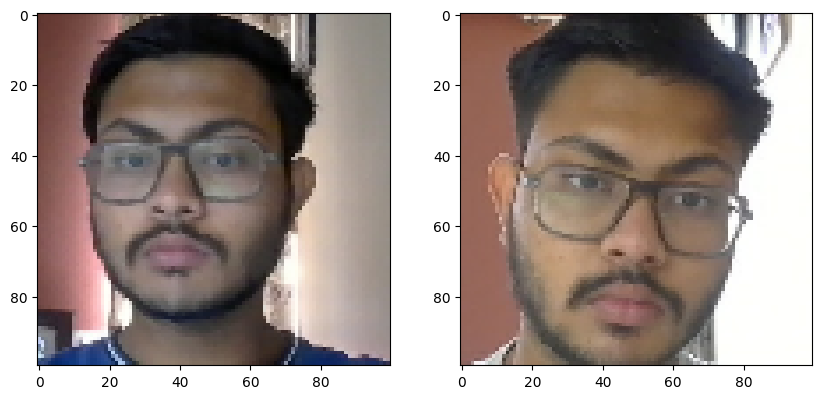

In [282]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [632]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [634]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [636]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.49961784],
       [0.49846658],
       [0.499672  ],
       [0.4989484 ]], dtype=float32)

In [638]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_8 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [654]:
application_data\verification_images


SyntaxError: unexpected character after line continuation character (4081098762.py, line 1)

In [656]:
os.listdir(os.path.join('application_data', 'verification_images'))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'application_data\\verification_images'

In [660]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [662]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'application_data\\verification_images'